In [80]:
import sqlite3 as sl
#from sklearn.neighbors import KernelDensity
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.spatial.distance import cdist

In [161]:
# Code taken from: https://gist.github.com/tillahoffmann/f844bce2ec264c1c8cb5
# https://stackoverflow.com/questions/27623919/weighted-gaussian-kernel-density-estimation-in-python
# http://nbviewer.ipython.org/gist/tillahoffmann/f844bce2ec264c1c8cb5
from six import string_types
class custom_gaussian_kde(object):
    """Representation of a kernel-density estimate using Gaussian kernels.

    Kernel density estimation is a way to estimate the probability density
    function (PDF) of a random variable in a non-parametric way.
    `gaussian_kde` works for both uni-variate and multi-variate data.   It
    includes automatic bandwidth determination.  The estimation works best for
    a unimodal distribution; bimodal or multi-modal distributions tend to be
    oversmoothed.

    Parameters
    ----------
    dataset : array_like
        Datapoints to estimate from. In case of univariate data this is a 1-D
        array, otherwise a 2-D array with shape (# of dims, # of data).
    bw_method : str, scalar or callable, optional
        The method used to calculate the estimator bandwidth.  This can be
        'scott', 'silverman', a scalar constant or a callable.  If a scalar,
        this will be used directly as `kde.factor`.  If a callable, it should
        take a `gaussian_kde` instance as only parameter and return a scalar.
        If None (default), 'scott' is used.  See Notes for more details.
    weights : array_like, shape (n, ), optional, default: None
        An array of weights, of the same shape as `x`.  Each value in `x`
        only contributes its associated weight towards the bin count
        (instead of 1).

    Attributes
    ----------
    dataset : ndarray
        The dataset with which `gaussian_kde` was initialized.
    d : int
        Number of dimensions.
    n : int
        Number of datapoints.
    neff : float
        Effective sample size using Kish's approximation.
    factor : float
        The bandwidth factor, obtained from `kde.covariance_factor`, with which
        the covariance matrix is multiplied.
    covariance : ndarray
        The covariance matrix of `dataset`, scaled by the calculated bandwidth
        (`kde.factor`).
    inv_cov : ndarray
        The inverse of `covariance`.

    Methods
    -------
    kde.evaluate(points) : ndarray
        Evaluate the estimated pdf on a provided set of points.
    kde(points) : ndarray
        Same as kde.evaluate(points)
    kde.pdf(points) : ndarray
        Alias for ``kde.evaluate(points)``.
    kde.set_bandwidth(bw_method='scott') : None
        Computes the bandwidth, i.e. the coefficient that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        .. versionadded:: 0.11.0
    kde.covariance_factor : float
        Computes the coefficient (`kde.factor`) that multiplies the data
        covariance matrix to obtain the kernel covariance matrix.
        The default is `scotts_factor`.  A subclass can overwrite this method
        to provide a different method, or set it through a call to
        `kde.set_bandwidth`.

    Notes
    -----
    Bandwidth selection strongly influences the estimate obtained from the KDE
    (much more so than the actual shape of the kernel).  Bandwidth selection
    can be done by a "rule of thumb", by cross-validation, by "plug-in
    methods" or by other means; see [3]_, [4]_ for reviews.  `gaussian_kde`
    uses a rule of thumb, the default is Scott's Rule.

    Scott's Rule [1]_, implemented as `scotts_factor`, is::

        n**(-1./(d+4)),

    with ``n`` the number of data points and ``d`` the number of dimensions.
    Silverman's Rule [2]_, implemented as `silverman_factor`, is::

        (n * (d + 2) / 4.)**(-1. / (d + 4)).

    Good general descriptions of kernel density estimation can be found in [1]_
    and [2]_, the mathematics for this multi-dimensional implementation can be
    found in [1]_.

    References
    ----------
    .. [1] D.W. Scott, "Multivariate Density Estimation: Theory, Practice, and
           Visualization", John Wiley & Sons, New York, Chicester, 1992.
    .. [2] B.W. Silverman, "Density Estimation for Statistics and Data
           Analysis", Vol. 26, Monographs on Statistics and Applied Probability,
           Chapman and Hall, London, 1986.
    .. [3] B.A. Turlach, "Bandwidth Selection in Kernel Density Estimation: A
           Review", CORE and Institut de Statistique, Vol. 19, pp. 1-33, 1993.
    .. [4] D.M. Bashtannyk and R.J. Hyndman, "Bandwidth selection for kernel
           conditional density estimation", Computational Statistics & Data
           Analysis, Vol. 36, pp. 279-298, 2001.

    Examples
    --------
    Generate some random two-dimensional data:

    >>> from scipy import stats
    >>> def measure(n):
    >>>     "Measurement model, return two coupled measurements."
    >>>     m1 = np.random.normal(size=n)
    >>>     m2 = np.random.normal(scale=0.5, size=n)
    >>>     return m1+m2, m1-m2

    >>> m1, m2 = measure(2000)
    >>> xmin = m1.min()
    >>> xmax = m1.max()
    >>> ymin = m2.min()
    >>> ymax = m2.max()

    Perform a kernel density estimate on the data:

    >>> X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    >>> positions = np.vstack([X.ravel(), Y.ravel()])
    >>> values = np.vstack([m1, m2])
    >>> kernel = stats.gaussian_kde(values)
    >>> Z = np.reshape(kernel(positions).T, X.shape)

    Plot the results:

    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> ax = fig.add_subplot(111)
    >>> ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r,
    ...           extent=[xmin, xmax, ymin, ymax])
    >>> ax.plot(m1, m2, 'k.', markersize=2)
    >>> ax.set_xlim([xmin, xmax])
    >>> ax.set_ylim([ymin, ymax])
    >>> plt.show()

    """
    def __init__(self, dataset, bw_method=None, weights=None):
        self.dataset = np.atleast_2d(dataset)
        if not self.dataset.size > 1:
            raise ValueError("`dataset` input should have multiple elements.")
        self.d, self.n = self.dataset.shape
            
        if weights is not None:
            self.weights = weights / np.sum(weights)
        else:
            self.weights = np.ones(self.n) / self.n
            
        # Compute the effective sample size 
        # http://surveyanalysis.org/wiki/Design_Effects_and_Effective_Sample_Size#Kish.27s_approximate_formula_for_computing_effective_sample_size
        self.neff = 1.0 / np.sum(self.weights ** 2)

        self.set_bandwidth(bw_method=bw_method)

    def evaluate(self, points):
        """Evaluate the estimated pdf on a set of points.

        Parameters
        ----------
        points : (# of dimensions, # of points)-array
            Alternatively, a (# of dimensions,) vector can be passed in and
            treated as a single point.

        Returns
        -------
        values : (# of points,)-array
            The values at each point.

        Raises
        ------
        ValueError : if the dimensionality of the input points is different than
                     the dimensionality of the KDE.

        """
        points = np.atleast_2d(points)

        d, m = points.shape
        if d != self.d:
            if d == 1 and m == self.d:
                # points was passed in as a row vector
                points = np.reshape(points, (self.d, 1))
                m = 1
            else:
                msg = "points have dimension %s, dataset has dimension %s" % (d,
                    self.d)
                raise ValueError(msg)

        # compute the normalised residuals
        chi2 = cdist(points.T, self.dataset.T, 'mahalanobis', VI=self.inv_cov) ** 2
        # compute the pdf
        result = np.sum(np.exp(-.5 * chi2) * self.weights, axis=1) / self._norm_factor

        return result

    __call__ = evaluate

    def scotts_factor(self):
        return np.power(self.neff, -1./(self.d+4))

    def silverman_factor(self):
        return np.power(self.neff*(self.d+2.0)/4.0, -1./(self.d+4))

    #  Default method to calculate bandwidth, can be overwritten by subclass
    covariance_factor = scotts_factor

    def set_bandwidth(self, bw_method=None):
        """Compute the estimator bandwidth with given method.

        The new bandwidth calculated after a call to `set_bandwidth` is used
        for subsequent evaluations of the estimated density.

        Parameters
        ----------
        bw_method : str, scalar or callable, optional
            The method used to calculate the estimator bandwidth.  This can be
            'scott', 'silverman', a scalar constant or a callable.  If a
            scalar, this will be used directly as `kde.factor`.  If a callable,
            it should take a `gaussian_kde` instance as only parameter and
            return a scalar.  If None (default), nothing happens; the current
            `kde.covariance_factor` method is kept.

        Notes
        -----
        .. versionadded:: 0.11

        Examples
        --------
        >>> x1 = np.array([-7, -5, 1, 4, 5.])
        >>> kde = stats.gaussian_kde(x1)
        >>> xs = np.linspace(-10, 10, num=50)
        >>> y1 = kde(xs)
        >>> kde.set_bandwidth(bw_method='silverman')
        >>> y2 = kde(xs)
        >>> kde.set_bandwidth(bw_method=kde.factor / 3.)
        >>> y3 = kde(xs)

        >>> fig = plt.figure()
        >>> ax = fig.add_subplot(111)
        >>> ax.plot(x1, np.ones(x1.shape) / (4. * x1.size), 'bo',
        ...         label='Data points (rescaled)')
        >>> ax.plot(xs, y1, label='Scott (default)')
        >>> ax.plot(xs, y2, label='Silverman')
        >>> ax.plot(xs, y3, label='Const (1/3 * Silverman)')
        >>> ax.legend()
        >>> plt.show()

        """
        if bw_method is None:
            pass
        elif bw_method == 'scott':
            self.covariance_factor = self.scotts_factor
        elif bw_method == 'silverman':
            self.covariance_factor = self.silverman_factor
        elif np.isscalar(bw_method) and not isinstance(bw_method, string_types):
            self._bw_method = 'use constant'
            self.covariance_factor = lambda: bw_method
        elif callable(bw_method):
            self._bw_method = bw_method
            self.covariance_factor = lambda: self._bw_method(self)
        else:
            msg = "`bw_method` should be 'scott', 'silverman', a scalar " \
                  "or a callable."
            raise ValueError(msg)

        self._compute_covariance()

    def _compute_covariance(self):
        """Computes the covariance matrix for each Gaussian kernel using
        covariance_factor().
        """
        self.factor = self.covariance_factor()
        # Cache covariance and inverse covariance of the data
        if not hasattr(self, '_data_inv_cov'):
            # Compute the mean and residuals
            _mean = np.sum(self.weights * self.dataset, axis=1)
            _residual = (self.dataset - _mean[:, None])
            # Compute the biased covariance
            self._data_covariance = np.atleast_2d(np.dot(_residual * self.weights, _residual.T))
            # Correct for bias (http://en.wikipedia.org/wiki/Weighted_arithmetic_mean#Weighted_sample_covariance)
            self._data_covariance /= (1 - np.sum(self.weights ** 2))
            self._data_inv_cov = np.linalg.inv(self._data_covariance)

        self.covariance = self._data_covariance * self.factor**2
        self.inv_cov = self._data_inv_cov / self.factor**2
        self._norm_factor = np.sqrt(np.linalg.det(2*np.pi*self.covariance)) #* self.n

In [30]:
dbfile = './web-application/database.db'
# Create a SQL connection to our SQLite database
con = sl.connect(dbfile)

# creating cursor
cur = con.cursor()
# reading all table names
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
# here is you table list
print(table_list)

# Be sure to close the connection
# con.close()

[('users',), ('activeSessions',), ('messages',), ('psychologists',), ('psychologistSessions',), ('userConversations',), ('clicks',), ('playbacks',)]


In [31]:
userIds = [a[0] for a in cur.execute("SELECT * FROM clicks")]
timestamps = [a[1] for a in cur.execute("SELECT * FROM clicks")]
presses = [a for a in cur.execute("SELECT * FROM clicks")]
# datetime.strptime(timestamps[0], "%Y-%m-%dT%H:%M:%S.%fZ")
playbacks = [a for a in cur.execute("SELECT * FROM playbacks")]
print(userIds)
print(timestamps)
print(playbacks)
con.close()


['b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'f874fe92-b190-496e-b12e-f6d8395e9503', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'ea43c33b-a737-474a-9389-b3b71564d3df', 'b4d4e615-06fb-4b70-b9c1-a51dfe59818d', 'f874fe92-b190-496e-b12e-f6d8395e9503',

In [33]:
datetime_objects = np.array([datetime.datetime.strptime(a, "%Y-%m-%dT%H:%M:%S.%fZ") for a in timestamps])
# Convert datetime objects to numerical values (e.g., timestamps)
numeric_values = np.array([dt.timestamp() for dt in datetime_objects])
datetimed_presses = []
for t in presses:
    datetimed_presses.append((t[0], datetime.datetime.strptime(t[1], "%Y-%m-%dT%H:%M:%S.%fZ")))
print(datetimed_presses)
datetimed_playbacks = []
for t in playbacks:
    datetimed_playbacks.append((t[0], datetime.datetime.strptime(t[1], "%Y-%m-%dT%H:%M:%S.%fZ")))
print(datetimed_playbacks)

[('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 22, 4, 810000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 22, 25, 99000)), ('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 22, 43, 84000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 13, 337000)), ('b4d4e615-06fb-4b70-b9c1-a51dfe59818d', datetime.datetime(2024, 2, 29, 15, 23, 11, 759000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 13, 408000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 16, 59000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 15, 552000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024, 2, 29, 15, 23, 21, 583000)), ('ea43c33b-a737-474a-9389-b3b71564d3df', datetime.datetime(2024, 2, 29, 15, 23, 21, 387000)), ('f874fe92-b190-496e-b12e-f6d8395e9503', datetime.datetime(2024

In [34]:
# Remove very old data
cleaned_presses = []
for datetime_object in datetimed_presses:
    if datetime_object[1].day == 4:
        cleaned_presses.append(datetime_object)

cleaned_playbacks = []
for playback in datetimed_playbacks:
    if playback[1].day == 4 and playback[1].hour > 12:
        cleaned_playbacks.append(playback)

print(cleaned_presses)
print(cleaned_playbacks)

[('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 38, 279000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 39, 304000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 39, 683000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 39, 886000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 40, 997000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 41, 289000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 41, 568000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 42, 727000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 42, 860000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4, 13, 33, 42, 995000)), ('2fe4c6fe-9639-47e4-a43b-3071d7a79ceb', datetime.datetime(2024, 3, 4

In [120]:
group1ids = []
group2ids = []
group3ids = []
for push in cleaned_presses:
    time = push[1]
    if time.hour == 13 and (time.minute == 37 and time.second > 55) or (time.minute == 38 and time.second < 7):
        group1ids.append(push[0])
    if time.hour == 13 and time.minute == 38 and time.second > 7 and time.second < 17:
        group2ids.append(push[0])
    if time.hour == 13 and time.minute == 38 and time.second > 17 and time.second < 52:
        group3ids.append(push[0])
group1uniqueids = np.unique(np.array(group1ids))
group2uniqueids = np.unique(np.array(group2ids))
group3uniqueids = np.unique(np.array(group3ids))
print(group1uniqueids)
print(group2uniqueids)
print(group3uniqueids)

part2group1ids = []
part2group2ids = []
part2group3ids = []
for push in cleaned_presses:
    time = push[1]
    if time.hour == 14 and time.minute == 11 and time.second > 28 and time.second < 45:
        part2group1ids.append(push[0])
    if time.hour == 14 and time.minute == 11 and time.second > 45 and time.second < 54:
        part2group2ids.append(push[0])
    if time.hour == 14 and ((time.minute == 11 and time.second > 54) or (time.minute == 12 and time.second < 9)):
        part2group3ids.append(push[0])
part2group1uniqueids = np.unique(np.array(part2group1ids))
part2group2uniqueids = np.unique(np.array(part2group2ids))
part2group3uniqueids = np.unique(np.array(part2group3ids))
print(part2group1uniqueids)
print(part2group2uniqueids)
print(part2group3uniqueids)

uniqueids = np.unique(np.concatenate((group1uniqueids, group2uniqueids, group3uniqueids, part2group1uniqueids, part2group2uniqueids, part2group3uniqueids)))
part1uniqueids = np.unique(np.concatenate((group1uniqueids, group2uniqueids, group3uniqueids)))
part2uniqueids = np.unique(np.concatenate((part2group1uniqueids, part2group2uniqueids, part2group3uniqueids)))
print(uniqueids)

['0af8b246-7932-497b-8e4a-a0026acfeab6'
 '6e360cc1-e4fb-42e6-8473-c872479fb10a'
 'a0ea20a4-ddcd-4dc4-ae1d-c39f659a4ccc'
 'c23ca581-d6b4-483c-a6ed-e9a319b00b3f']
['5e50fb1f-9612-4144-aaf0-bb3d96734164'
 '71e955ab-307e-455f-b671-ba6b04b3a0a7'
 '7e16969c-380d-4f45-9eee-b58044c72dca'
 'aaf0ef53-bc69-478a-b263-f8a5073db117']
['2fe4c6fe-9639-47e4-a43b-3071d7a79ceb'
 '523a04ee-b335-488d-804e-ea8fc0fb30a0'
 '64a23a81-4dab-444d-8203-cac0654a36ee'
 'cf8d3d91-a739-478b-92fa-0cacdff18576']
['0af8b246-7932-497b-8e4a-a0026acfeab6'
 '1a16b64e-5d51-42bc-9fe9-f53db17cea04'
 '6e360cc1-e4fb-42e6-8473-c872479fb10a'
 'c23ca581-d6b4-483c-a6ed-e9a319b00b3f']
['5e50fb1f-9612-4144-aaf0-bb3d96734164'
 '71e955ab-307e-455f-b671-ba6b04b3a0a7'
 '7e16969c-380d-4f45-9eee-b58044c72dca'
 'aaf0ef53-bc69-478a-b263-f8a5073db117']
['523a04ee-b335-488d-804e-ea8fc0fb30a0'
 '64a23a81-4dab-444d-8203-cac0654a36ee'
 'cf8d3d91-a739-478b-92fa-0cacdff18576'
 'cf9331cc-fdb0-4c65-91ee-1d705f92c14f']
['0af8b246-7932-497b-8e4a-a0026acf

In [44]:
last_pb = cleaned_playbacks[0]
periodised_playbacks = []
for i in range(len(cleaned_playbacks)):
    pb = cleaned_playbacks[i]
    start_time = last_pb[1]
    end_time = pb[1]
    duration = end_time-start_time
    title = last_pb[0]
    periodised_playbacks.append((title, start_time, end_time, duration))
    last_pb = pb
periodised_playbacks.append((cleaned_playbacks[-1][0], cleaned_playbacks[-1][1], (cleaned_playbacks[-1][1] + datetime.timedelta(0,1200)), datetime.timedelta(0,1200)))
print(periodised_playbacks)


[('test-player', datetime.datetime(2024, 3, 4, 13, 35, 20, 206000), datetime.datetime(2024, 3, 4, 13, 35, 20, 206000), datetime.timedelta(0)), ('test-player', datetime.datetime(2024, 3, 4, 13, 35, 20, 206000), datetime.datetime(2024, 3, 4, 13, 37, 55, 720000), datetime.timedelta(seconds=155, microseconds=514000)), ('group1', datetime.datetime(2024, 3, 4, 13, 37, 55, 720000), datetime.datetime(2024, 3, 4, 13, 37, 57, 196000), datetime.timedelta(seconds=1, microseconds=476000)), ('group1', datetime.datetime(2024, 3, 4, 13, 37, 57, 196000), datetime.datetime(2024, 3, 4, 13, 37, 57, 739000), datetime.timedelta(microseconds=543000)), ('group1', datetime.datetime(2024, 3, 4, 13, 37, 57, 739000), datetime.datetime(2024, 3, 4, 13, 38, 7, 684000), datetime.timedelta(seconds=9, microseconds=945000)), ('group2', datetime.datetime(2024, 3, 4, 13, 38, 7, 684000), datetime.datetime(2024, 3, 4, 13, 38, 17, 149000), datetime.timedelta(seconds=9, microseconds=465000)), ('group3', datetime.datetime(2024

In [140]:
round_one = ["player2", "player5", "player6", "player7"]
round_two = ["player11", "player13", "player18", "player19"]
part_1_group_unique_ids = [group1uniqueids, group2uniqueids, group3uniqueids]
part_2_group_unique_ids = [part2group1uniqueids, part2group2uniqueids, part2group3uniqueids]
groups = [1, 2, 3]

# periodised_playbacks
# cleaned_presses
clip_pools = []
for pb in periodised_playbacks:
    group_pools = []
    for group in groups:
        individual_pools = []
        for person in uniqueids:
            individual_pool = []
            for click in cleaned_presses:
                
                if (click[0] == person and ((pb[0] in round_one and person in part_1_group_unique_ids[group-1]) or (pb[0] in round_two and person in part_2_group_unique_ids[group-1]))):
                    #print(click[1])
                    individual_pool.append(click[1])
            individual_pools.append((person, individual_pool))
        group_pools.append((group, individual_pools))
    clip_pools.append((pb[0], group_pools))

'''
for clip in clip_pools:
    print("-----" + clip[0] + "-----")
    for group in clip[1]:
        print("group " + str(group[0]))
        for person in group[1]:
            print(person[0] + ": " + str(len(person[1])))
'''

'\nfor clip in clip_pools:\n    print("-----" + clip[0] + "-----")\n    for group in clip[1]:\n        print("group " + str(group[0]))\n        for person in group[1]:\n            print(person[0] + ": " + str(len(person[1])))\n'

Final pool
[1.70955574e+09 1.70955575e+09 1.70955575e+09 1.70955588e+09
 1.70955588e+09 1.70955588e+09 1.70955614e+09 1.70955647e+09
 1.70955713e+09 1.70955789e+09 1.70955789e+09 1.70955789e+09
 1.70955864e+09 1.70955869e+09 1.70955575e+09 1.70955575e+09
 1.70955575e+09 1.70955588e+09 1.70955588e+09 1.70955588e+09
 1.70955596e+09 1.70955614e+09 1.70955614e+09 1.70955614e+09
 1.70955644e+09 1.70955647e+09 1.70955713e+09 1.70955789e+09
 1.70955789e+09 1.70955789e+09 1.70955824e+09 1.70955864e+09
 1.70955868e+09 1.70955869e+09 1.70955886e+09 1.70955574e+09
 1.70955575e+09 1.70955575e+09 1.70955588e+09 1.70955588e+09
 1.70955588e+09 1.70955596e+09 1.70955615e+09 1.70955644e+09
 1.70955647e+09 1.70955672e+09 1.70955713e+09 1.70955574e+09
 1.70955575e+09 1.70955575e+09 1.70955588e+09 1.70955588e+09
 1.70955596e+09 1.70955614e+09 1.70955644e+09 1.70955647e+09
 1.70955673e+09 1.70955713e+09 1.70955789e+09 1.70955789e+09
 1.70955789e+09 1.70955824e+09 1.70955864e+09 1.70955868e+09
 1.70955869e+

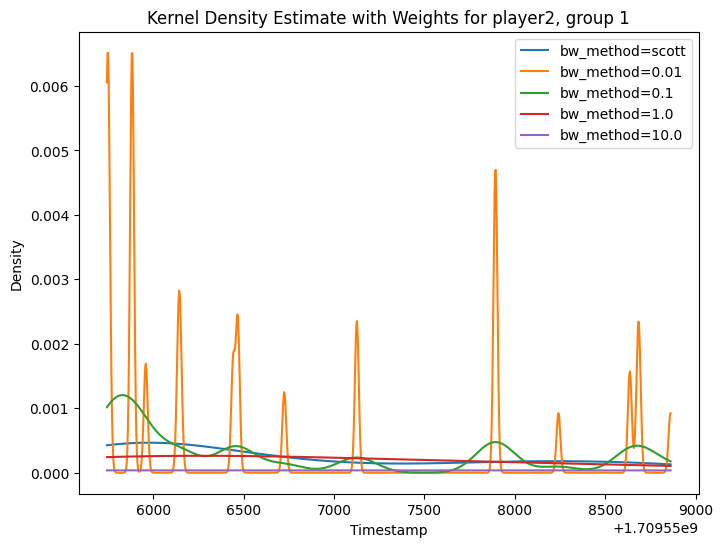

Final pool
[1.70955574e+09 1.70955575e+09 1.70955575e+09 1.70955589e+09
 1.70955589e+09 1.70955589e+09 1.70955613e+09 1.70955615e+09
 1.70955619e+09 1.70955624e+09 1.70955634e+09 1.70955635e+09
 1.70955639e+09 1.70955643e+09 1.70955648e+09 1.70955650e+09
 1.70955670e+09 1.70955671e+09 1.70955679e+09 1.70955680e+09
 1.70955688e+09 1.70955702e+09 1.70955702e+09 1.70955703e+09
 1.70955712e+09 1.70955713e+09 1.70955791e+09 1.70955791e+09
 1.70955791e+09 1.70955796e+09 1.70955798e+09 1.70955799e+09
 1.70955800e+09 1.70955802e+09 1.70955803e+09 1.70955803e+09
 1.70955804e+09 1.70955804e+09 1.70955808e+09 1.70955820e+09
 1.70955821e+09 1.70955823e+09 1.70955827e+09 1.70955829e+09
 1.70955830e+09 1.70955832e+09 1.70955842e+09 1.70955843e+09
 1.70955853e+09 1.70955853e+09 1.70955858e+09 1.70955860e+09
 1.70955861e+09 1.70955864e+09 1.70955864e+09 1.70955864e+09
 1.70955865e+09 1.70955865e+09 1.70955866e+09 1.70955866e+09
 1.70955867e+09 1.70955873e+09 1.70955873e+09 1.70955873e+09
 1.70955873e+

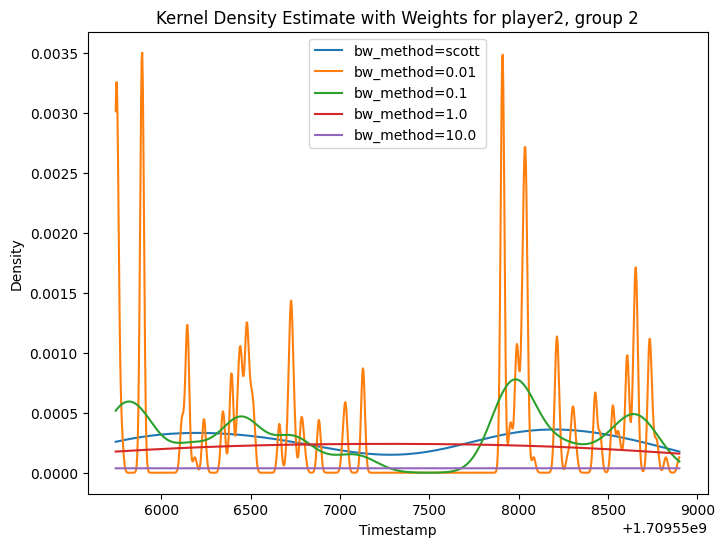

Final pool
[1.70955562e+09 1.70955562e+09 1.70955562e+09 1.70955562e+09
 1.70955562e+09 1.70955562e+09 1.70955562e+09 1.70955562e+09
 1.70955562e+09 1.70955562e+09 1.70955563e+09 1.70955563e+09
 1.70955574e+09 1.70955575e+09 1.70955575e+09 1.70955590e+09
 1.70955590e+09 1.70955590e+09 1.70955596e+09 1.70955603e+09
 1.70955614e+09 1.70955616e+09 1.70955616e+09 1.70955623e+09
 1.70955624e+09 1.70955639e+09 1.70955640e+09 1.70955643e+09
 1.70955644e+09 1.70955646e+09 1.70955647e+09 1.70955648e+09
 1.70955649e+09 1.70955672e+09 1.70955678e+09 1.70955681e+09
 1.70955683e+09 1.70955685e+09 1.70955686e+09 1.70955688e+09
 1.70955702e+09 1.70955703e+09 1.70955712e+09 1.70955713e+09
 1.70955713e+09 1.70955714e+09 1.70955714e+09 1.70955575e+09
 1.70955575e+09 1.70955575e+09 1.70955590e+09 1.70955590e+09
 1.70955590e+09 1.70955615e+09 1.70955623e+09 1.70955653e+09
 1.70955673e+09 1.70955713e+09 1.70955792e+09 1.70955792e+09
 1.70955792e+09 1.70955803e+09 1.70955830e+09 1.70955849e+09
 1.70955873e+

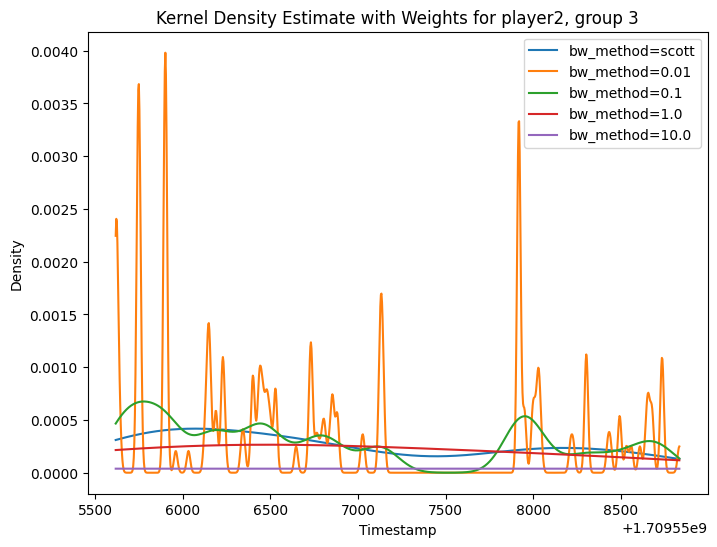

In [162]:
# Varying kernel size using different bw_method values
bw_methods = ['scott', 0.01, 0.1, 1.0, 10.0]  # Different bandwidths


for clip in clip_pools:
    #print("Clip " + clip[0])
    if(clip[0] not in round_one and clip[0] not in round_two):
        continue
    for group in clip[1]:
        #print("Group " + str(group[0]))

        

        final_pool = np.zeros(0)
        weights = np.zeros(0)

        for individual in group[1]:
            
            individual_numeric_values = [dt.timestamp() for dt in individual[1]]
            individual_weights = [1/len(individual[1]) for dt in individual[1]]
            
            individual_numeric_values = np.array(individual_numeric_values)
            individual_weights = np.array(individual_weights)
            
            final_pool = np.concatenate((final_pool, individual_numeric_values))
            weights = np.concatenate((weights, individual_weights))

        # Perform KDE with weights
        print("Final pool")
        print(final_pool)
        print("Final weights")
        print(weights)
        kde = custom_gaussian_kde(dataset=final_pool, weights=weights, bw_method="scott")

        # Set up the range of values for which to estimate the density
        x_values = np.linspace(min(final_pool), max(final_pool), 1000)

        

        plt.figure(figsize=(8, 6))

        for bw_method in bw_methods:
            kde = custom_gaussian_kde(dataset=final_pool, weights=weights, bw_method=bw_method)
            density_estimate = kde.evaluate(x_values)
            plt.plot(x_values, density_estimate, label=f'bw_method={bw_method}')

        
        
        plt.xlabel('Timestamp')
        plt.ylabel('Density')
        plt.title('Kernel Density Estimate with Weights for ' + clip[0] + ", group " + str(group[0]))

        plt.legend()
        plt.show()
    if clip[0] == "player2":
        break
    


In [7]:
# Varying kernel size using different bw_method values
bw_methods = ['scott', 0.01, 0.1, 1.0, 10.0]  # Different bandwidths

# Perform KDE
kde = gaussian_kde(numeric_values)

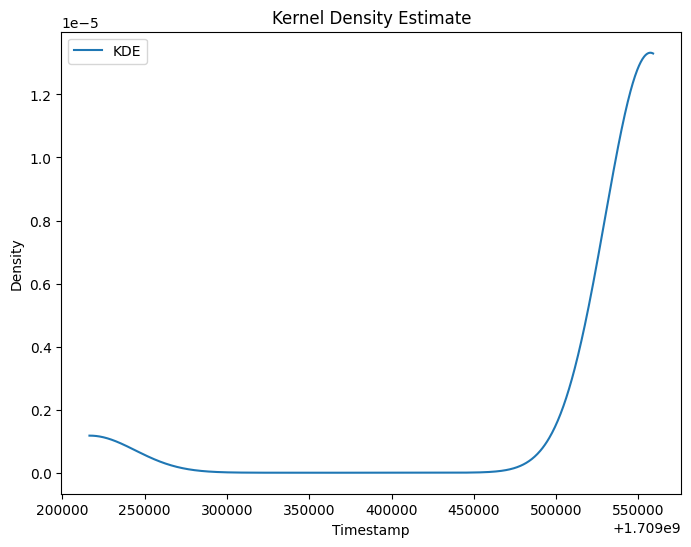

In [8]:
# Set up the range of values for which to estimate the density
x_values = np.linspace(min(numeric_values), max(numeric_values), 1000)

# Evaluate the KDE at the specified points
density_estimate = kde(x_values)

# Plotting the KDE
plt.figure(figsize=(8, 6))
plt.plot(x_values, density_estimate, label='KDE')
plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Kernel Density Estimate')
plt.legend()
plt.show()

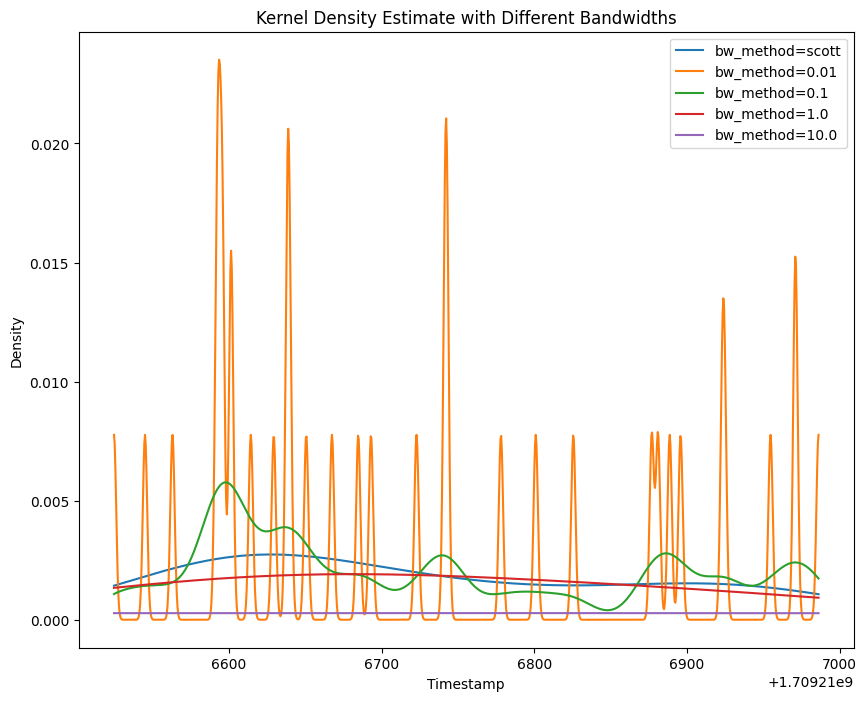

In [24]:
plt.figure(figsize=(10, 8))
for bw_method in bw_methods:
    kde = gaussian_kde(numeric_values, bw_method=bw_method)
    x_values = np.linspace(min(numeric_values), max(numeric_values), 1000)
    density_estimate = kde(x_values)
    plt.plot(x_values, density_estimate, label=f'bw_method={bw_method}')

plt.xlabel('Timestamp')
plt.ylabel('Density')
plt.title('Kernel Density Estimate with Different Bandwidths')
plt.legend()
plt.show()